# <center>ASTR4004/8004 - Inference - Part 1</center> 

## Bayes' theorem:
$$
P(\theta|D)=P(D|\theta)\frac{P(\theta)}{P(D)}
$$

* $P(D|\theta)$: the likelihood function, representing the probability of observing the data ($D$) given a specific set of modeling parameters ($\theta$)
* $P(\theta)$: the prior probability distribution over the modeling parameters ($\theta$). This represents our initial beliefs of possible values of $\theta$
* $P(D)\equiv \sum \limits_{\theta} P(D,\theta)=\sum \limits_{\theta} P(D|\theta)P(\theta) = \int {\rm d}\theta P(\theta) P(D|\theta)$: the marginal likelihood or Bayesian evidence, representing the overall probability of observing the data (D)
* $P(\theta|D)$: the posterior probability distribution over the modeling parameters ($\theta$) given the data.

This notebook fits the distribution of a dataset within a Bayesian framework. The model  considered here is a Normal distribution with the mean fixed and the variance treated as a free parameter.

## Useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Data (D) and the task
We will be given a dataset and the task is to find a distribution to fit it

Text(0, 0.5, 'PDF')

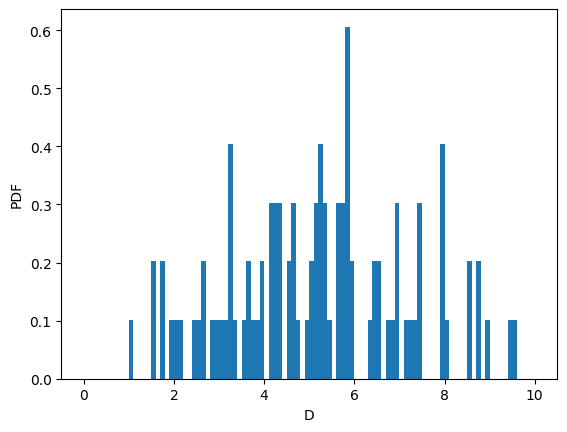

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Generate dataset (100 data points) following a normal distribution
mean_real, std_real = 5, 2
n_data = 100
data = np.random.normal(loc=mean_real, scale=std_real, size=n_data)
plt.hist(data, bins=100, range=(0,10), density=True)
plt.xlabel('D')
plt.ylabel('PDF')

## Propose your model
* It "seems" that our dataset $D$ follows a normal distribution. So we decide to fit it using a normal distribution.
* In fact, let's do even simpler, I will also begin by estimating what the mean should be.
* Therefore, out parameter $\theta$ corresponds to the standard deviation (`std`)

## Write a generic function to sample from a 1D parameter space (`x`) based on any given `pdf(x)`

### inverse CDF sampling
Also known as the inverse transform sampling method, it is a technique used to generate random samples from a probability distribution given its cumulative distribution function:
* The cumulative distribution function $F(x)$ of a random variable $X$ describes the probability that $X$ takes on a value less than or equal to $x$: $$F(x)=P(X\leq x)$$
* Generate a random number $U$ from a uniform distribution over the interval [0,1], which represents a probability.
* Use the inverse of the CDF, $F^{-1}(u)$ to transform the uniform random variable $U$ to a sample fromo the target distribution: $$X=F^{-1}(U),$$ i.e., since $U$ is uniformly distributed, the tranformation ensures that the output $X$ is distributed according to $F$.
* Example: $$F(x)=1-e^{-\lambda x},$$ $$x=F^{-1}(y) = \frac{1}{\lambda}\ln{\left(1-y\right)}$$
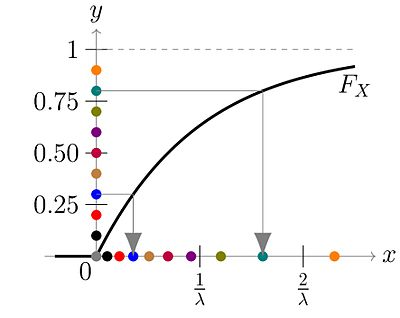

In [3]:
from scipy.interpolate import interp1d

def sample_parameters(pdf, x_min, x_max, num_samples):
    '''
    Inverse CDF sampling

    Parameters:
    - pdf: the target PDF to sample
    - x_min, x_max: range to sample 
    - num_samples: the number of sample to generate

    Return:
    - x_samples: the sample that following the given pdf 
    '''
    
    x_samples = np.zeros(num_samples)
    
    xs = np.linspace(x_min, x_max, 1000)
    pdfs = np.zeros(1000)
    for i in range(1000):
        pdfs[i] = pdf(xs[i])
    cdf = np.cumsum(pdfs)
    cdf /= cdf[-1]

    inverse_cdf = interp1d(cdf, xs, bounds_error=False, fill_value=(x_min, x_max))
    random_values = np.random.uniform(0, 1, num_samples)
    x_samples = inverse_cdf(random_values)

    return x_samples

### uniform between $x\in[-1,1]$

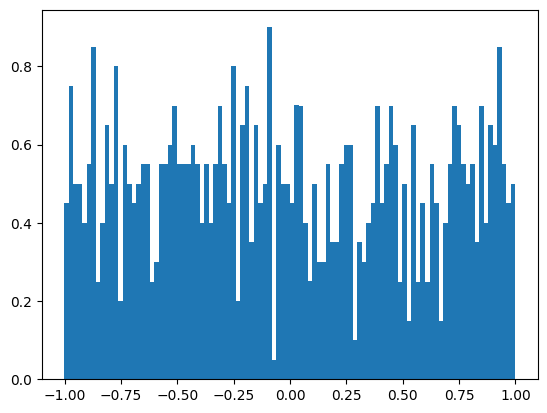

In [4]:
def pdf(x):
    if x<-1 or x>1:
        return 0
    else:
        return 0.5
    
x_samples = sample_parameters(pdf, -2, 2, 1000)
plt.hist(x_samples, density=True, bins=100);

## Normal distribution

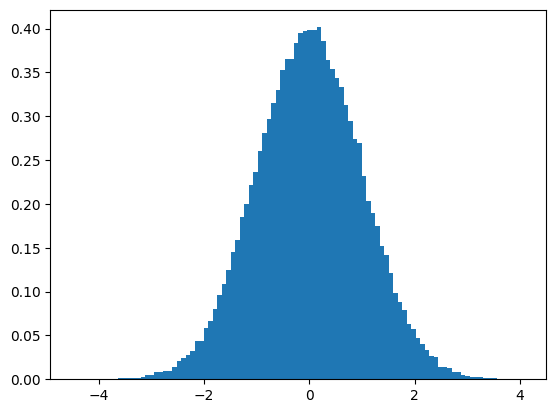

In [5]:
def norm_pdf(x, mean, std):
    return np.exp(-((x-mean)/std)**2 / 2) / (std * np.sqrt(2 * np.pi))

def pdf(x):
    return norm_pdf(x, 0, 1)
    
x_samples = sample_parameters(pdf, -5, 5, 100000)
plt.hist(x_samples, density=True, bins=100);

## Define the prior of your model parametersm

In [6]:
std_min, std_max   = 1, 3

# an uninformative prior
def initial_prior(std):
    if std < std_min or std > std_max:
        return 0
    else:
        return 1/(std_max - std_min)

## Calculate the likelihood 
We have picked the Normal distribution as our model, then for a given set of model parameters, $\theta$ or $\sigma$ (`std`), the likelihood function of data $D$ or `x` is simply 
$$
P(D|\theta) \equiv P(x|\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp{\left[-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right]}.
$$
Note that here we assume we know what the mean ($\mu$) is.

In [7]:
def likelihood(x, mean, std):
    return norm_pdf(x, mean, std)

## A bit of a detour - Monte Carlo

Before jumping into Bayesian inference, it's worth spending some time on the background to understand *why* Monte Carlo is such an important tool for generating samples from the posterior. Let's start with a description of just plane old Monte Carlo sampling.

Consider the problem where we have some parameter $x$ that follows some distribution function $p$ (e.g. uniform, Normal or any unknown shape). Let's say we would like to compute the expectation value of a function that depends on $x$, $g(x)$, defined as 

\begin{equation}
\mathbb{E}_{p(x)}\left[g(x)\right]= \int g(x)\,p(x)\,dx.
\end{equation}

In the case of complex (or unknown) $p(x)$, this integration can be challenging and/or costly to compute. The Monte Carlo approximation allows us to estimate the integral above using discrete samples drawn from $p(x)$, i.e.

\begin{equation}
\mathbb{E}_{p(x)}\left[g(x)\right] \approx \frac{1}{N} \sum_{n=1}^{N} g(x^{(n)}).
\end{equation}

If samples are independent, then the variance on the mean is given by

\begin{equation}
\sigma^2 = \frac{1}{N} {\rm Var}_{p(x)}\left[g(x)\right],
\end{equation}

which is to say that the approximated expectation value follow the expected result that its variance decreases as the number of samples increases. 

## Bayesian inference

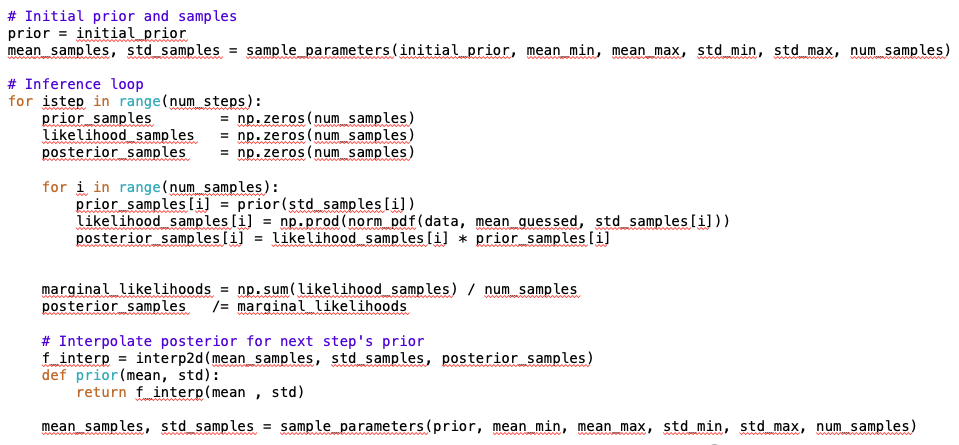

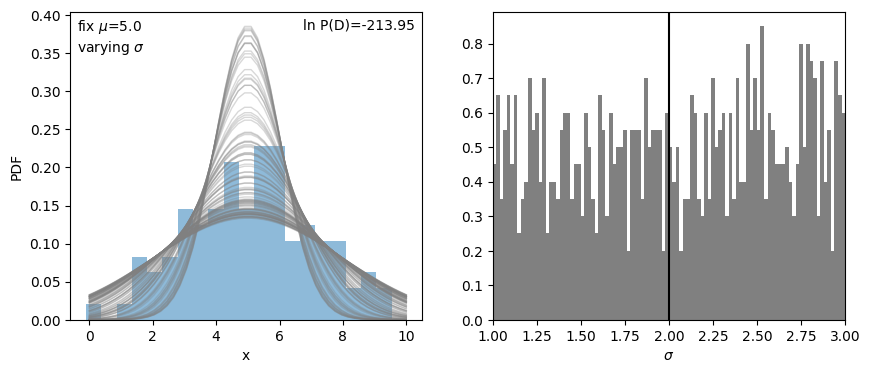

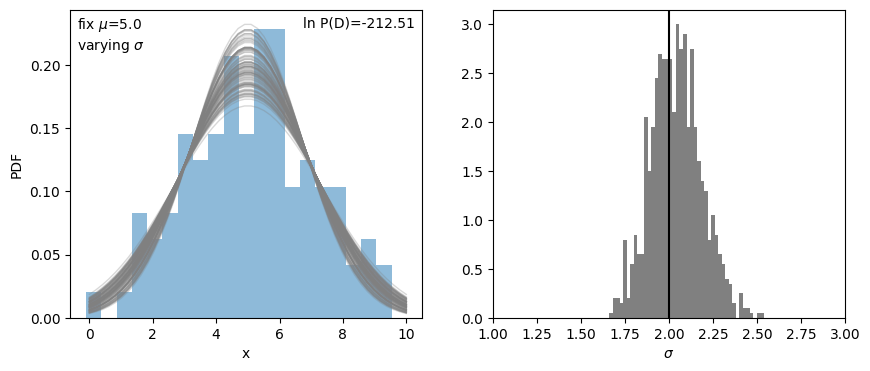

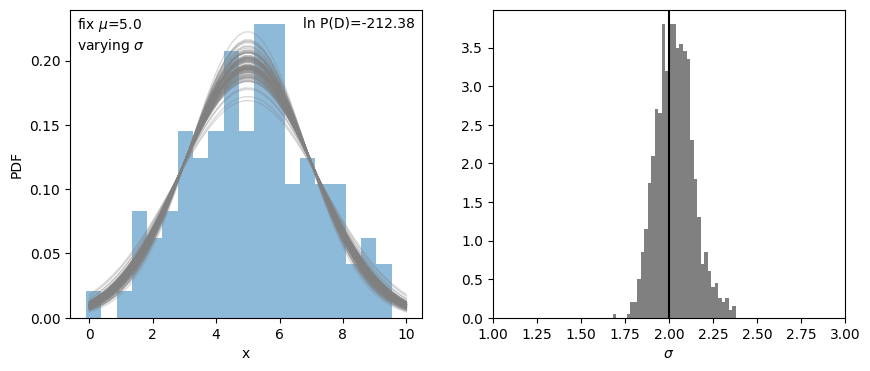

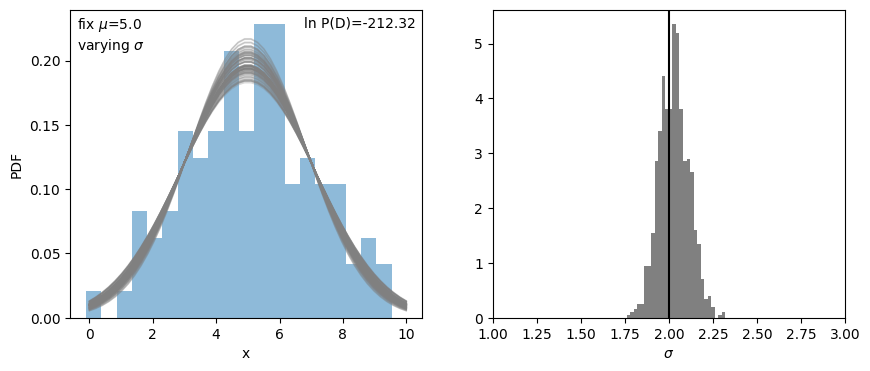

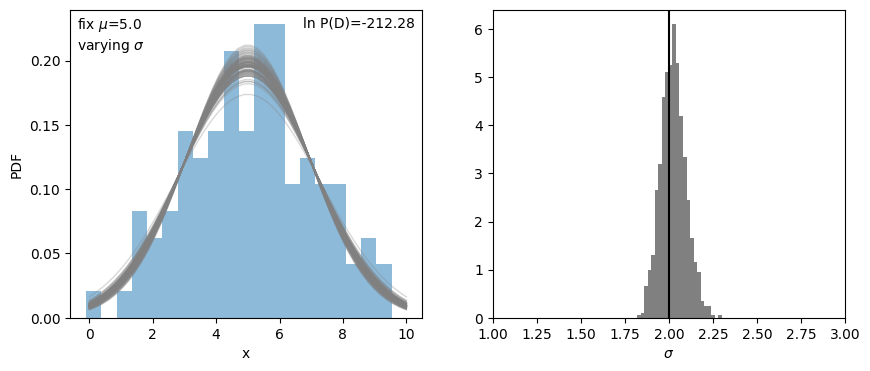

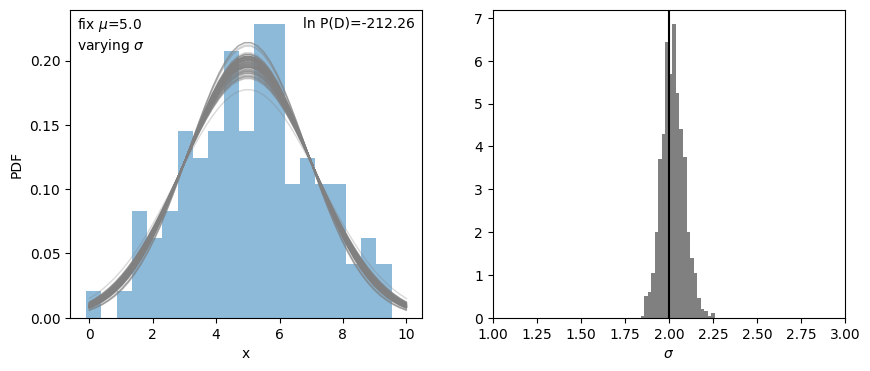

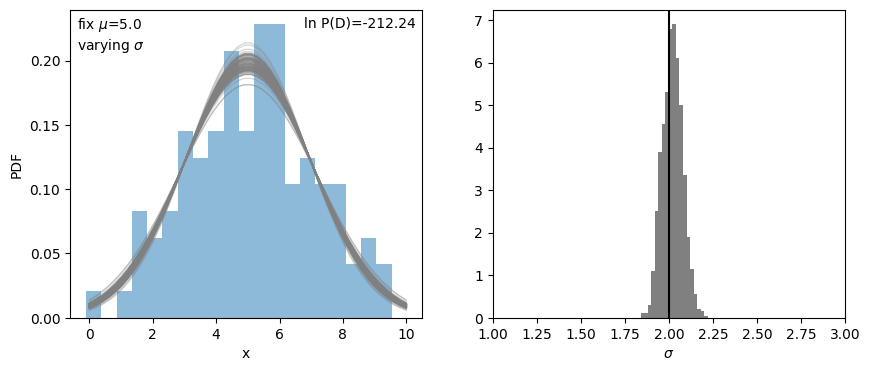

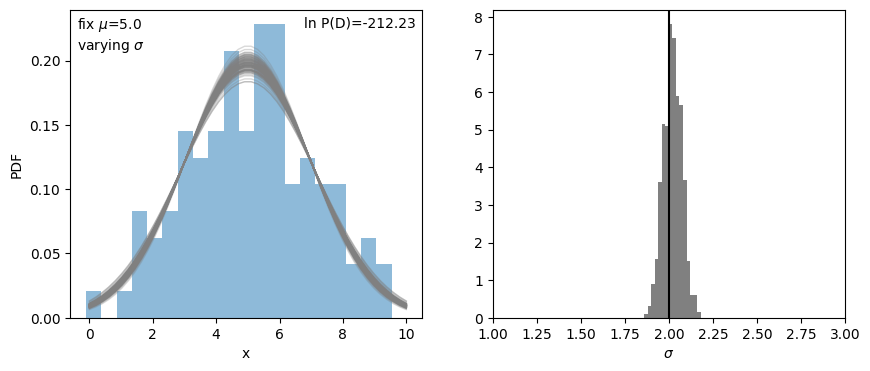

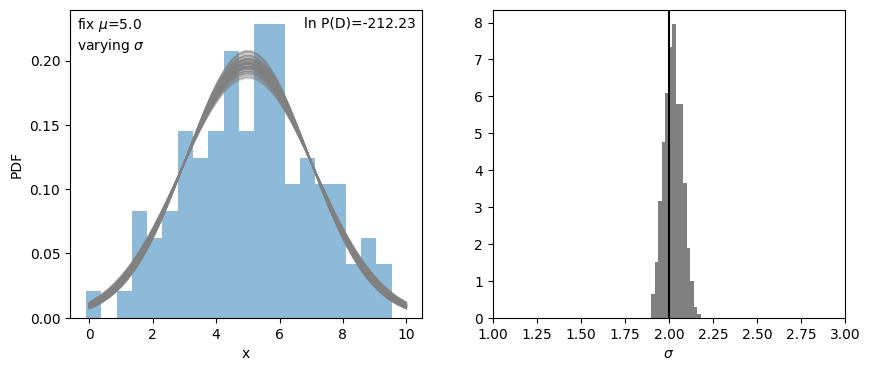

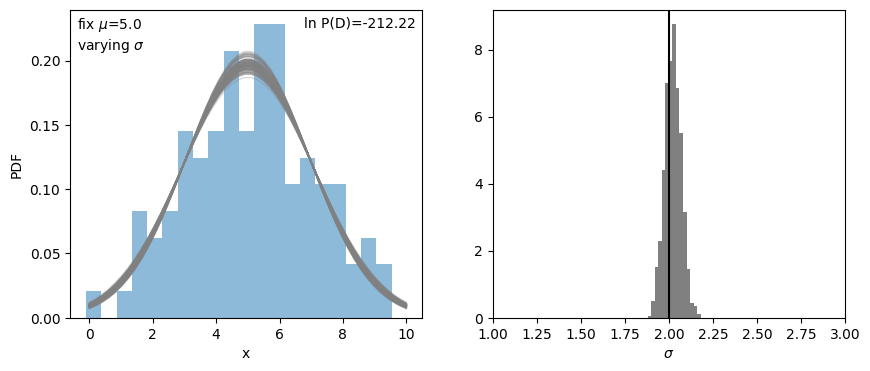

In [8]:
num_samples = 1000 # Number of samples in the parameter space
num_steps = 10 # Number of inteferencing steps
xs = np.linspace(0,10) # for plotting modelled distribution

# sample parameters based on the initial prior
prior = initial_prior
std_samples = sample_parameters(initial_prior, std_min, std_max, num_samples)
mean_guessed = 5

prior_samples        = np.zeros(num_samples)
likelihood_samples   = np.zeros(num_samples)
posterior_samples    = np.zeros(num_samples)

# Inference loop
for istep in range(num_steps):
    
    # calculate prior, likelihood, marginal likelihood and posterior 
    for i in range(num_samples):
        prior_samples[i] = prior(std_samples[i])
        likelihood_samples[i] = np.prod(norm_pdf(data, mean_guessed, std_samples[i]))

        # Baye's rule
        posterior_samples[i] = prior_samples[i] * likelihood_samples[i]

    marginal_likelihoods = np.sum(likelihood_samples) / num_samples
    posterior_samples   /= marginal_likelihoods
    
    # Plot the data distrbution
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].hist(data, bins=20, alpha=0.5, density=True)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('PDF')

    # Randomly pick a few samples and plot our modelled distribution
    for idx in np.random.randint(0, num_samples, size=100):
        axs[0].plot(xs, norm_pdf(xs, mean_guessed, std_samples[idx]) , lw=1, alpha=0.3, c='grey')

    # Print the marginal likelihood
    axs[0].text(0.98, 0.98, r'ln P(D)=%.2f'%np.log(marginal_likelihoods), 
               ha='right', va='top', transform=axs[0].transAxes)
    axs[0].text(0.02, 0.98, r'fix $\mu$=%.1f'%mean_guessed+'\n'+r'varying $\sigma$',
               ha='left', va='top', transform=axs[0].transAxes)

    # Plot the 1D distribution of model parameter
    axs[1].hist(std_samples, range=(std_min, std_max), 
                bins=100, density=True, color='grey')

    # Show the truth
    axs[1].axvline(std_real, color='k')

    axs[1].set_xlim(std_min, std_max)
    axs[1].set_xlabel(r'$\sigma$')

    # now consider the posterior as prior for the next inferecing step
    f_interp = interp1d(std_samples, posterior_samples, bounds_error=True)
    def prior(std):
        try: return f_interp(std)
        except: return 0
    
    std_samples = sample_parameters(prior, std_min, std_max, num_samples)

change your initial guess of the mean and observe how the marginal likelihood changes.

<font color='red'> Also note the *caveat* that the marginal likelihood here is weighted by the updated prior in each step, rather than using the intial prior. Therefore, we are biased towards high probability regions. In addition, points in a sample might only have a uniform volume when initialized to be uniform and are very likely not the case at later times! </font>
